# Modern Portfolio Theory (Markowitz) - Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global Variable RFR
r = 0.04

In [15]:
%store -r b_zlamb
%store -r b_varlamb
%store -r zlamb
%store -r varlamb

In [16]:
def get_data(choice):
    """
    Given a choice ("exercice" or "real"), reads the CSV file and extracts
    the expected return 'mus' and the covariance matrix 'cov'.

    Parameters:
    - choice (str): Specifies whether to use data for the "exercice" or "real" scenario.

    Returns:
    tuple: A tuple containing two elements:
        - mus (pd.Series): Expected returns for each asset.
        - cov (pd.DataFrame): Covariance matrix of asset returns.
    """

    # Validate the choice input
    while choice not in ['exercice', 'real']:
        choice = input("Input 'exercice' or 'real': ")

    # Load data based on the choice
    if choice == 'exercice':
        daily_returns = pd.read_csv('resources/MVM_data.csv')
        mus = daily_returns['mu'].set_axis(daily_returns['cov'])
        cov = daily_returns.iloc[:, 2:].set_axis(daily_returns['cov'])
    elif choice == 'real':
        daily_returns = pd.read_csv('resources/daily_returns.csv').set_index('Date')
        daily_returns = daily_returns * 100
        mus = daily_returns.mean()
        cov = daily_returns.cov()

    return mus, cov

### Generate Random Basic Portfolios

In [17]:
def generate_random_basic_portfolios(mus, cov):
    """
    Generates random portfolios based on the mean and covariance matrix.

    Parameters:
    - mus (pd.Series): Expected returns for each asset.
    - cov (pd.DataFrame): Covariance matrix of asset returns.

    Returns:
    pd.DataFrame: DataFrame containing randomly generated portfolios with their mean return,
                  standard deviation, and Sharpe ratio.
    """

    # Set random seed for reproducibility
    np.random.seed(50)

    # Number of assets
    n_assets = len(cov.columns)

    # Number of portfolios to generate
    n_portfolios = 5000

    # Initialize DataFrame to store portfolio statistics
    mean_variance_df = pd.DataFrame(columns=['Mean', 'Std', 'Sharpe Ratio'])

    # Generate random portfolios
    for p in range(n_portfolios):
        # Generate random weights, normalize to ensure they sum to 1
        weights = np.random.rand(n_assets)
        weights /= sum(weights)

        # Calculate portfolio return, variance, and Sharpe ratio
        portfolio_return = np.matmul(np.transpose(weights), mus)
        portfolio_variance = np.matmul(np.transpose(weights), np.matmul(cov, weights))
        sharpe = (portfolio_return) / np.sqrt(portfolio_variance)

        # Add portfolio statistics to the DataFrame
        new_row = pd.DataFrame({'Mean': portfolio_return,
                                'Std': np.sqrt(portfolio_variance),
                                'Sharpe Ratio': sharpe},
                               index=[p])
        mean_variance_df = pd.concat([mean_variance_df, new_row])

    return mean_variance_df

### Generate Random RFR Portfolios

In [18]:
def generate_random_RFR_portfolios(mus, cov, r):
    """
    Generates random portfolios based on the mean, covariance matrix, and risk-free rate.

    Parameters:
    - mus (pd.Series): Expected returns for each asset.
    - cov (pd.DataFrame): Covariance matrix of asset returns.
    - r (float): Risk-free rate.

    Returns:
    pd.DataFrame: DataFrame containing randomly generated portfolios with their mean return,
                  standard deviation, and Sharpe ratio.
    """

    # Set risk-free rate for all assets
    mus['RFR'] = r

    # Set random seed for reproducibility
    np.random.seed(50)

    # Number of portfolios to generate
    n_portfolios = 5000

    # Number of assets
    n_assets = len(mus)

    # Initialize DataFrame to store portfolio statistics
    mean_variance_df = pd.DataFrame(columns=['Mean', 'Std', 'Sharpe Ratio'])

    # Generate random portfolios
    for p in range(n_portfolios):
        # Generate random weights, normalize to ensure they sum to 1
        weights = np.random.rand(n_assets)
        weights /= sum(weights)

        # Calculate portfolio return, variance, and Sharpe ratio
        portfolio_return = np.matmul(np.transpose(weights), mus)
        portfolio_variance = np.matmul(np.transpose(weights[:-1]), np.matmul(cov, weights[:-1]))
        sharpe = (portfolio_return - r) / np.sqrt(portfolio_variance)

        # Add portfolio statistics to the DataFrame
        new_row = pd.DataFrame({'Mean': portfolio_return,
                                'Std': np.sqrt(portfolio_variance),
                                'Sharpe Ratio': sharpe},
                               index=[p])
        mean_variance_df = pd.concat([mean_variance_df, new_row])

    return mean_variance_df

### Minimum Variance Frontier

In [19]:
def minimum_variance_frontier(mean_variance_df):
    """
    Computes the minimum variance frontier by grouping portfolios based on their mean returns
    and selecting the portfolio with the minimum standard deviation from each group.

    Parameters:
    - mean_variance_df (pd.DataFrame): DataFrame containing portfolios with mean return, standard deviation,
      and Sharpe ratio.

    Returns:
    pd.DataFrame: DataFrame representing the minimum variance frontier, containing portfolios with
                  the minimum standard deviation from each mean return group.
    """

    # Number of buckets to group portfolios based on mean return
    n_buckets = 8

    # Create mean buckets by cutting the mean return into specified bins
    mean_variance_df['Mean_Bucket'] = pd.cut(mean_variance_df['Mean'], bins=n_buckets)

    # Initialize a list to store the indices of portfolios with minimum standard deviation in each bucket
    min_std_indices = []

    # Iterate over groups based on mean buckets
    for _, group in mean_variance_df.groupby('Mean_Bucket'):
        if not group.empty:
            min_std_indices.append(group['Std'].idxmin())

    # Extract portfolios with minimum standard deviation from each group to form the frontier
    frontier_df = mean_variance_df.loc[min_std_indices]

    return frontier_df

### Plot Simulation

In [36]:
def plot_simulation(mean_variance_df, frontier_df, mus, cov, title):
    """
    Plots a simulation of random portfolios, the minimum variance frontier, and individual stocks.

    Parameters:
    - mean_variance_df (pd.DataFrame): DataFrame containing portfolios with mean return, standard deviation,
      and Sharpe ratio.
    - frontier_df (pd.DataFrame): DataFrame representing the minimum variance frontier.
    - mus (pd.Series): Expected returns for each asset.
    - cov (pd.DataFrame): Covariance matrix of asset returns.
    - title (str): Title of the plot.

    Returns:
    None
    """

    # Create a figure with a specified size
    plt.figure(figsize=(12, 8))

    # Scatter plot for random portfolios colored by Sharpe ratio
    scatter = plt.scatter(mean_variance_df['Std'], mean_variance_df['Mean'], c=mean_variance_df['Sharpe Ratio'], cmap='viridis', alpha=0.8, label='Random Portfolios')
    plt.colorbar(scatter, shrink=0.5, aspect=5, label='Sharpe Ratio')

    # Plot the minimum variance frontier
    plt.plot(frontier_df['Std'].to_numpy(), frontier_df['Mean'].to_numpy(), c='red', label='Approximated MVP Frontier')

    # Scatter plot for individual stocks
    variances = cov.to_numpy().diagonal()
    plt.scatter(np.sqrt(variances), mus, c='black', marker='+', s=100, label='Individual Stocks')

    if title == 'Exercice Basic Portfolios':
        # Minimum Variance w/o R
        plt.plot(np.sqrt(b_varlamb), b_zlamb, c='gray',
                 label='Basic Minimum Variance')
        plt.xlim(0, 7)
        plt.ylim(-0.05,1.2)

    elif title == 'Exercice RFR Portfolios':
        # Efficient Frontier
        plt.plot(np.sqrt(np.split(varlamb, 2)[1]), np.split(zlamb, 2)[1], c='green',
                 label='RFR Efficient Frontier')
        plt.xlim(0, 7)
        plt.ylim(-0.05,1.2)

    # Set labels and title
    plt.xlabel('Std.')
    plt.ylabel('Expected Returns')
    plt.title(title)

    # Add legend and display the plot
    plt.legend()
    plt.show()

### Simulation with Exercice Data

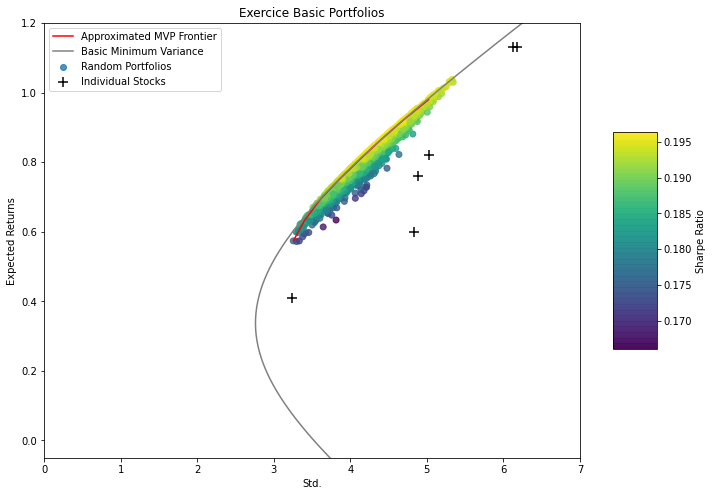

In [37]:
mus, cov = get_data('exercice')
mean_variance_df = generate_random_basic_portfolios(mus, cov)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df, mus, cov, 'Exercice Basic Portfolios')

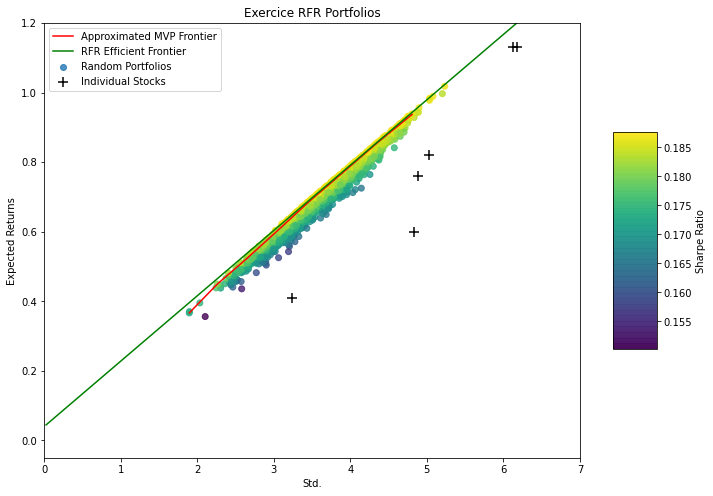

In [38]:
mus, cov = get_data('exercice')
mean_variance_df = generate_random_RFR_portfolios(mus, cov, r)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df,  mus[:-1], cov, 'Exercice RFR Portfolios')

### Simulation with Real Data

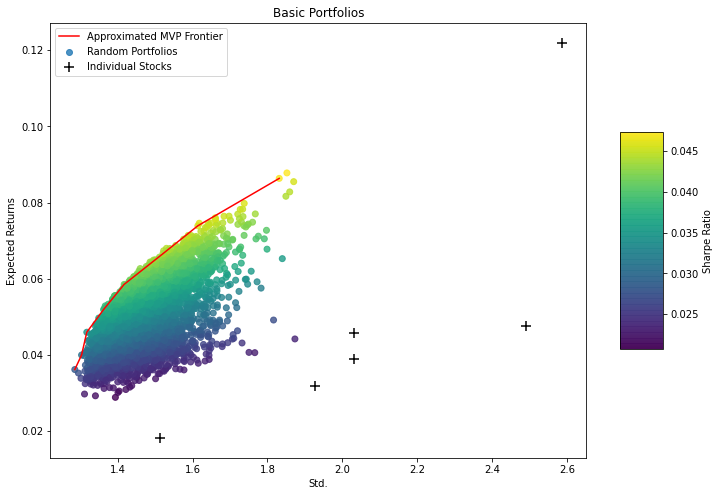

In [39]:
mus, cov = get_data('real')
mean_variance_df = generate_random_basic_portfolios(mus, cov)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df,  mus, cov, 'Basic Portfolios')

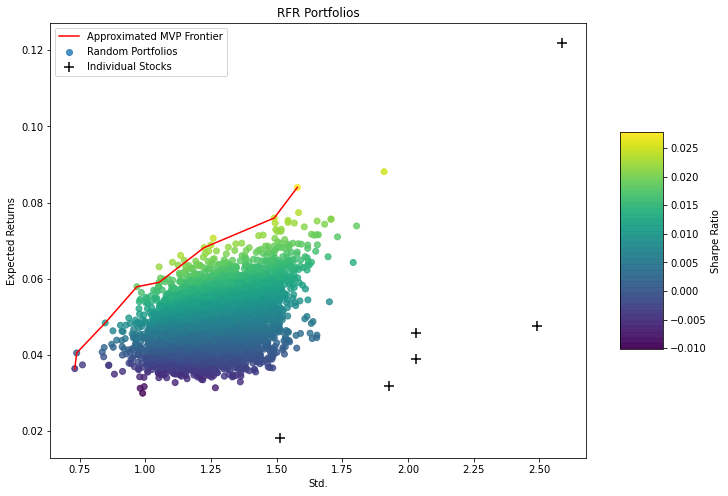

In [40]:
mus, cov = get_data('real')
mean_variance_df = generate_random_RFR_portfolios(mus, cov, r)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df, mus[:-1], cov, 'RFR Portfolios')